In [1]:
import json
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import pandas_profiling
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from datetime import datetime

import itertools
import math


from trueskill import Rating, quality_1vs1, rate_1vs1, setup, global_env, TrueSkill, rate

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix


setup(mu=25.0, sigma=8.333333333333334, beta=4.166666666666667,
      tau=0.08333333333333334, draw_probability=0)


trueskill.TrueSkill(mu=25.000, sigma=8.333, beta=4.167, tau=0.083, draw_probability=0.0%)

In [118]:
def kelly_criterion(odds, prob, frac):
    output = (prob * (odds - 1) - (1 - prob)) / (odds - 1)

    # Output is divided to reduce volatilty
    output = output / frac
    return(output)


def apply_kelly(odds1, odds2, prob1, prob2):
    odds = [odds1, odds2]
    prob = [prob1, prob2]
    output = list(map(lambda x, y: round(
        kelly_criterion(x, y, 10), 2), odds, prob))
    output = list(map(lambda x: abs(max(x, float(0))), output))
    return(output)


def returns(O1, O2, B1, B2, O):

    loss = B1 + B2

    if O == 1:
        gain = B1 * O1

    if O == 2:
        gain = B2 * O2

    profit = round(gain - loss, 5)
    return(profit)


def plot_performance(returns, title):

    # Converting to numpy array and applying cumulative product function
    array = np.array(returns)
    cumulative_returns = np.cumprod(1 + array) - 1

    plt.figure(figsize=(15, 10))
    plt.style.use('seaborn-white')
    plt.plot(cumulative_returns)

    plt.title(title, fontsize=30)
    # _, accuracy = clf.evaluate(X_test, y_test)
    plt.suptitle("acc: " + str("accuracy"), fontsize=25)
    plt.ylabel('return', fontsize=15, labelpad=20)
    plt.xlabel('number of bets', fontsize=15, labelpad=20)
    plt.axhline(0, linewidth=0.8, color='black', linestyle=':')


def win_probability(team1, team2, BETA=4.166666666666667, decimal=3):
    delta_mu = sum(r.mu for r in team1) - sum(r.mu for r in team2)
    sum_sigma = sum(r.sigma ** 2 for r in itertools.chain(team1, team2))
    size = len(team1) + len(team2)
    denom = math.sqrt(size * (BETA * BETA) + sum_sigma)
    ts = global_env()
    return round(ts.cdf(delta_mu / denom), decimal)


def trueskill_row(row):
    w_id = row.Team1 if row.Winner == 1 else row.Team2
    l_id = row.Team2 if row.Winner == 1 else row.Team1

    #get current TS
    w_ts_before = current_ts["Rating"].iloc[w_id]
    l_ts_before = current_ts["Rating"].iloc[l_id]

    #update TS
    w_ts_after, l_ts_after = rate_1vs1(w_ts_before, l_ts_before)

    #  getwinchance
    w_winchance = win_probability([w_ts_before], [l_ts_before])
    l_winchance = 1-w_winchance

    current_ts.iloc[w_id] = w_ts_after
    current_ts.iloc[l_id] = l_ts_after

    return w_ts_before, l_ts_before, w_ts_after, l_ts_after, w_winchance, l_winchance


In [3]:
with open('C:\REPOS\CSGO\main.json') as f:
  data = json.load(f)


In [128]:
Elo = pd.DataFrame(columns=["MatchID", "Team1",
                            "Team2", "Team1Odds", "Team2Odds", "Winner"])
for matchid in data.keys():
    t1, t2 = data[matchid].get("Teams")
    s1, s2 = data[matchid].get("Score")
    if data[matchid].get("Odds") != "No odds available":
        o1, o2 = data[matchid].get("Odds")
    else: o1,o2 = np.nan,np.nan

    winner = 1 if s1 > s2 else 2
    Elo = Elo.append({"MatchID": matchid, "Team1": t1,
                      "Team2": t2, "Team1Odds":o1, "Team2Odds":o2, "Winner": winner}, ignore_index=True)

teams = pd.concat([pd.DataFrame(Elo.Team1.unique()),
                   pd.DataFrame(Elo.Team2.unique())])
teams = teams[0].unique()
teams = pd.DataFrame(teams)


In [5]:
# Elo.Team1Odds = Elo.Team1Odds.astype(float)
# Elo.Team2Odds = Elo.Team2Odds.astype(float)
# Elo.iloc[(np.where(Elo.Team1Odds == "-", 1, 0))]

#Find the one fucking "-"
Elo.loc[Elo['Team1Odds'] == "-"]
Elo.drop(6626,axis=0,inplace=True)
Elo.Team1Odds = Elo.Team1Odds.astype(float)
Elo.Team2Odds = Elo.Team2Odds.astype(float)


In [6]:
# print(len(Elo))
# len(Elo) - Elo["Team1Odds"].isna().sum()

In [117]:
len(teams)


683

In [122]:
# reset or create Dataframe
trueskill_df = Elo.copy()

#label encoding:
le = LabelEncoder()

le.fit(teams)

trueskill_df.Team1 = le.transform(trueskill_df.Team1)
trueskill_df.Team2 = le.transform(trueskill_df.Team2)

trueskill_df['Team1winchance'] = 0.0
trueskill_df['Team2winchance'] = 0.0

trueskill_df['w_ts_after_game'] = Rating()
trueskill_df['l_ts_after_game'] = Rating()

trueskill_df['w_ts_before_game'] = Rating()
trueskill_df['l_ts_before_game'] = Rating()

n_teams = len(teams)
current_ts = pd.DataFrame(np.full(n_teams, Rating()))
current_ts["Team"] = current_ts.index
current_ts.columns = ["Rating", "Team"]
current_ts["Team"] = le.inverse_transform(current_ts["Team"])


C:\Users\timrs\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [123]:
trueskill_df_na = trueskill_df.copy()
trueskill_df.dropna(inplace=True)

In [127]:
trueskill_df


,0
0,248
1,455
2,56
3,558
4,111
...,...
351,12
352,585
353,14
354,525


In [125]:
trueskill_df.to_csv("Trueskill.csv",index=False)

In [119]:
summ = []
# for i in range(0,len(trueskill_df)):
for i in range(0,10):
    ID = trueskill_df['MatchID'].iloc[i]
    # print(ID)
    Team1Odds = trueskill_df['Team1Odds'].iloc[i]
    Team2Odds = trueskill_df['Team2Odds'].iloc[i]

    w_ts_before, l_ts_before, w_ts_after, l_ts_after, w_winchance, l_winchance = trueskill_row(
        trueskill_df.iloc[i])

    if trueskill_df["Winner"].iloc[i] == 1:
        Team1winchance = w_winchance
        Team2winchance = l_winchance

    if trueskill_df["Winner"].iloc[i] == 2:
        Team2winchance = w_winchance
        Team1winchance = l_winchance

    # print(Team1winchance, Team2winchance, Team1Odds, Team2Odds)
    y_preds = clf.predict_proba(
        [[Team1winchance, Team2winchance, Team1Odds, Team2Odds]])
    # print(y_preds[0,0])

    a, b = apply_kelly(Team1Odds, Team2Odds, y_preds[0, 0], y_pred[0, 1])
    if a < 0:
        a = 0
    if b < 0:
        b = 0
    
    # print(apply_kelly(Team1Odds,Team2Odds,y_preds[0,0],y_pred[0,1]))
    rets = returns(Team1Odds, Team2Odds, a, b, trueskill_df["Winner"].iloc[i])
    # print(rets)
    summ.append(rets)
    # print("\n")
np.sum(summ)



0.7223999999999999

In [111]:
summ = pd.Series(summ)

In [106]:
summ.head(25)

0    0.0324
1    0.3500
2    0.1400
3    0.0000
4    0.0000
5    0.0000
6    0.0000
7   -0.0300
8   -0.0200
9    0.2600
dtype: float64

In [112]:
c = np.prod(1+summ)-1
c


4.130357136308268

In [9]:
# trueskill_row(trueskill_df.iloc[0])
# current_ts.iloc[0]
# row = trueskill_df.iloc[0]


In [27]:
for i in range(0,len(trueskill_df)):
# for i in range(0,5):
    # trueskill_row(trueskill_df.iloc[i])
    w_ts_before, l_ts_before, w_ts_after, l_ts_after, w_winchance, l_winchance  = trueskill_row(trueskill_df.iloc[i])

    # print(w_ts_before, l_ts_before, w_ts_after,
        #   l_ts_after, w_winchance, l_winchance)

    if trueskill_df["Winner"].iloc[i] == 1:
        trueskill_df['Team1winchance'].iloc[i] = w_winchance
        trueskill_df['Team2winchance'].iloc[i] = l_winchance
    if trueskill_df["Winner"].iloc[i] == 2:
        trueskill_df['Team1winchance'].iloc[i] = l_winchance
        trueskill_df['Team2winchance'].iloc[i] = w_winchance

    trueskill_df['w_ts_before_game'].iloc[i] = w_ts_before
    trueskill_df['w_ts_after_game'].iloc[i] = w_ts_after
    trueskill_df['l_ts_before_game'].iloc[i] = l_ts_before
    trueskill_df['l_ts_after_game'].iloc[i] = l_ts_after


C:\Users\timrs\anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [28]:
trueskill_df_na = trueskill_df.copy()
trueskill_df.dropna(inplace=True)

In [22]:
# temp = trueskill_df.drop(columns=["Team1Odds","Team2Odds"])
trueskill_df.to_csv("broken_trueskill.csv",index=False)


In [13]:
X = trueskill_df[["MatchID","Team1Odds", "Team2Odds",
                  "Team1winchance", "Team2winchance"]].copy()
X.set_index("MatchID", inplace=True)



y = trueskill_df[["MatchID"]].copy()
y["Outcome"] = trueskill_df["Winner"].replace((1,2),(0,1))
y.set_index("MatchID",inplace=True)


X_test_odds = X[["Team1Odds","Team2Odds"]]
X

,Team1Odds,Team2Odds,Team1winchance,Team2winchance
MatchID,,,,
2314256,1.44,2.62,0.499,0.501
2313887,1.06,8.00,0.545,0.455
2313888,1.16,4.50,0.651,0.349
2313889,2.00,1.72,0.626,0.374
2313890,2.62,1.44,0.454,0.546
...,...,...,...,...
2348006,1.66,2.10,0.506,0.494
2348008,2.10,1.66,0.600,0.400
2348009,1.72,2.00,0.397,0.603


In [14]:
X["Team1Odds"] = X.apply(lambda x: 1/x[0], axis=1)
X["Team2Odds"] = X.apply(lambda x: 1/x[1], axis=1)
X

,Team1Odds,Team2Odds,Team1winchance,Team2winchance
MatchID,,,,
2314256,0.694444,0.381679,0.499,0.501
2313887,0.943396,0.125000,0.545,0.455
2313888,0.862069,0.222222,0.651,0.349
2313889,0.500000,0.581395,0.626,0.374
2313890,0.381679,0.694444,0.454,0.546
...,...,...,...,...
2348006,0.602410,0.476190,0.506,0.494
2348008,0.476190,0.602410,0.600,0.400
2348009,0.581395,0.500000,0.397,0.603


In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y)
#
#  RF ----------------------------------------------------------------------------------
clf = RandomForestClassifier(
    n_estimators=500, min_samples_split=2, max_features="sqrt", max_depth=30)
#Params: {'n_estimators': 1600, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 70, 'bootstrap': False}


# clf = SGDClassifier(loss="log", max_iter=2000)

#clf = XGBClassifier(booster="gblinear", objective="binary:logistic", use_label_encoder=False,
#  n_estimators=1000, early_stopping_rounds=100, verbosity=1)


clf.fit(X_train, y_train)

y_pred_acc = clf.predict(X_test)
y_pred = clf.predict_proba(X_test)

acc_score = accuracy_score(y_test, y_pred_acc)
print("Acc: ", acc_score)


<ipython-input-15-d7ce40cb5c90>:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train, y_train)


Acc:  0.5391705069124424


In [16]:
# KELLY PREP FUNCTIONING
kelly_data = pd.DataFrame()

# Kelly Odds and Outcome
X_test_odds = X_test.merge(y_test, left_index=True, right_index=True)
kelly_data = X_test_odds[["Team1Odds", "Team2Odds", "Outcome"]].copy()

#Add and Reset ID
kelly_data['ID'] = X_test_odds.index.astype(int)
kelly_data.reset_index(drop=True, inplace=True)


# Kelly Predicitions
y_pred = clf.predict_proba(X_test)
kelly_data['ProbTeam1'] = pd.DataFrame(y_pred)[0]
kelly_data['ProbTeam2'] = pd.DataFrame(y_pred)[1]
kelly_data['prediction'] = pd.DataFrame(y_pred_acc)
kelly_data['Outcome'].replace([0, 1], [1, 2], inplace=True)
kelly_data['prediction'].replace([0, 1], [1, 2], inplace=True)
kelly_data["Team1Odds"] = kelly_data.apply(lambda x: 1/x[0], axis=1)
kelly_data["Team2Odds"] = kelly_data.apply(lambda x: 1/x[1], axis=1)

#Set Index to ID and name cols
kelly_data.set_index('ID', inplace=True)
kelly_data.columns = ["Team1Odds", "Team2Odds", "Outcome",
                      "ProbTeam1", "ProbTeam2", "prediction"]





In [23]:
kelly_data

,Team1Odds,Team2Odds,Outcome,ProbTeam1,ProbTeam2,prediction,Kelly1,Kelly2
ID,,,,,,,,
2328211,1.61,2.20,2,0.470000,0.530000,2,0.00,0.01
2331049,1.08,7.00,2,0.210000,0.790000,2,0.00,0.08
2340937,1.72,2.00,2,0.337464,0.662536,2,0.00,0.03
2348002,1.72,2.00,1,0.136546,0.863454,2,0.00,0.07
2333422,1.05,8.50,1,0.350167,0.649833,2,0.00,0.06
...,...,...,...,...,...,...,...,...
2343772,1.25,3.75,1,0.714000,0.286000,1,0.00,0.00
2317483,1.22,4.00,2,0.902000,0.098000,1,0.05,0.00
2317605,1.40,2.75,1,0.512134,0.487866,1,0.00,0.02


<ipython-input-2-8795bcb9ec58>:2: RuntimeWarning: divide by zero encountered in double_scalars
  output = (prob * (odds - 1) - (1 - prob)) / (odds - 1)


3773.9158259308647


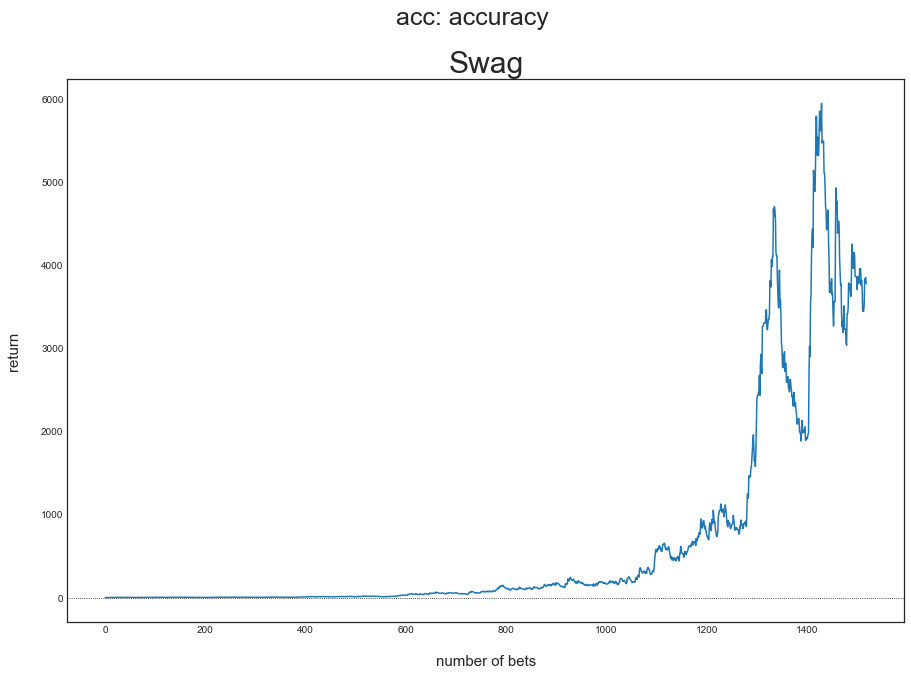

In [17]:
kelly_data[["Kelly1", "Kelly2"]] = kelly_data.apply(lambda row: apply_kelly(
    row.Team1Odds, row.Team2Odds, row.ProbTeam1,row.ProbTeam2), result_type="expand", axis=1)
# def apply_kelly(odds1, odds2, prob1, prob2):


res = kelly_data.apply(lambda row: returns(
    row.Team1Odds, row.Team2Odds, row.Kelly1, row.Kelly2, row.Outcome), axis=1)
#def returns(O1,O2,B1,B2,O):


# def kelly_criterion(odds, prob, frac):


# PLOT

plot_performance(res, title="Swag")
print(np.prod(1+res)-1)


# ALL IN ONE

In [18]:
X

,Team1Odds,Team2Odds,Team1winchance,Team2winchance
MatchID,,,,
2314256,0.694444,0.381679,0.499,0.501
2313887,0.943396,0.125000,0.545,0.455
2313888,0.862069,0.222222,0.651,0.349
2313889,0.500000,0.581395,0.626,0.374
2313890,0.381679,0.694444,0.454,0.546
...,...,...,...,...
2348006,0.602410,0.476190,0.506,0.494
2348008,0.476190,0.602410,0.600,0.400
2348009,0.581395,0.500000,0.397,0.603


In [19]:
result = []
max_iter = 5

for i in range(0, max_iter):

    X_train, X_test, y_train, y_test = train_test_split(X, y)
    #
    #  RF ----------------------------------------------------------------------------------
    clf = RandomForestClassifier(
        n_estimators=500, min_samples_split=2, max_features="sqrt", max_depth=30)
    #Params: {'n_estimators': 1600, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 70, 'bootstrap': False}


    # clf = SGDClassifier(loss="log", max_iter=2000)

    #clf = XGBClassifier(booster="gblinear", objective="binary:logistic", use_label_encoder=False,
    #  n_estimators=1000, early_stopping_rounds=100, verbosity=1)


    clf.fit(X_train, y_train["Outcome"])

    y_pred_acc = clf.predict(X_test)
    y_pred = clf.predict_proba(X_test)

    acc_score = accuracy_score(y_test, y_pred_acc)
    print("Acc: ", acc_score)

    # ---------------------------------------------------

    # KELLY PREP FUNCTIONING
    kelly_data = pd.DataFrame()

    # Kelly Odds and Outcome
    X_test_odds = X_test.merge(y_test, left_index=True, right_index=True)
    kelly_data = X_test_odds[["Team1Odds", "Team2Odds", "Outcome"]].copy()

    #Add and Reset ID
    kelly_data['ID'] = X_test_odds.index.astype(int)
    kelly_data.reset_index(drop=True, inplace=True)


    # Kelly Predicitions
    y_pred = clf.predict_proba(X_test)
    kelly_data['ProbTeam1'] = pd.DataFrame(y_pred)[0]
    kelly_data['ProbTeam2'] = pd.DataFrame(y_pred)[1]
    kelly_data['prediction'] = pd.DataFrame(y_pred_acc)
    kelly_data['Outcome'].replace([0, 1], [1, 2], inplace=True)
    kelly_data['prediction'].replace([0, 1], [1, 2], inplace=True)
    kelly_data["Team1Odds"] = kelly_data.apply(lambda x: 1/x[0], axis=1)
    kelly_data["Team2Odds"] = kelly_data.apply(lambda x: 1/x[1], axis=1)

    #Set Index to ID and name cols
    kelly_data.set_index('ID', inplace=True)
    kelly_data.columns = ["Team1Odds", "Team2Odds", "Outcome",
                        "ProbTeam1", "ProbTeam2", "prediction"]


    # ---------------------------------------------------



    kelly_data[["Kelly1", "Kelly2"]] = kelly_data.apply(lambda row: apply_kelly(
        row.Team1Odds, row.Team2Odds, row.ProbTeam1, row.ProbTeam2), result_type="expand", axis=1)
    # def apply_kelly(odds1, odds2, prob1, prob2):


    res = kelly_data.apply(lambda row: returns(
        row.Team1Odds, row.Team2Odds, row.Kelly1, row.Kelly2, row.Outcome), axis=1)
    #def returns(O1,O2,B1,B2,O):


    # PLOT
    result.append(np.prod(1+res)-1)
    print(str(i) + ": " + str(np.prod(1+res)-1))



Acc:  0.5385121790651745


<ipython-input-2-8795bcb9ec58>:2: RuntimeWarning: divide by zero encountered in double_scalars
  output = (prob * (odds - 1) - (1 - prob)) / (odds - 1)


0: 424.20792887747365
Acc:  0.5378538512179065


<ipython-input-2-8795bcb9ec58>:2: RuntimeWarning: divide by zero encountered in double_scalars
  output = (prob * (odds - 1) - (1 - prob)) / (odds - 1)
<ipython-input-2-8795bcb9ec58>:2: RuntimeWarning: invalid value encountered in double_scalars
  output = (prob * (odds - 1) - (1 - prob)) / (odds - 1)


1: 132.5158552030726
Acc:  0.5358788676761027


<ipython-input-2-8795bcb9ec58>:2: RuntimeWarning: divide by zero encountered in double_scalars
  output = (prob * (odds - 1) - (1 - prob)) / (odds - 1)
<ipython-input-2-8795bcb9ec58>:2: RuntimeWarning: invalid value encountered in double_scalars
  output = (prob * (odds - 1) - (1 - prob)) / (odds - 1)


2: 176.39021062295703
Acc:  0.5424621461487821


<ipython-input-2-8795bcb9ec58>:2: RuntimeWarning: divide by zero encountered in double_scalars
  output = (prob * (odds - 1) - (1 - prob)) / (odds - 1)


3: 93.97967849232057
Acc:  0.5457537853851218
4: 91.86337127915269


<ipython-input-2-8795bcb9ec58>:2: RuntimeWarning: divide by zero encountered in double_scalars
  output = (prob * (odds - 1) - (1 - prob)) / (odds - 1)
<ipython-input-2-8795bcb9ec58>:2: RuntimeWarning: invalid value encountered in double_scalars
  output = (prob * (odds - 1) - (1 - prob)) / (odds - 1)


In [20]:
row = kelly_data.iloc[935]

apply_kelly(
    row.Team1Odds, row.Team2Odds, row.ProbTeam1, row.ProbTeam2)
kelly_data.iloc[935]


Team1Odds     1.330
Team2Odds     3.250
Outcome       2.000
ProbTeam1     0.572
ProbTeam2     0.428
prediction    1.000
Kelly1        0.000
Kelly2        0.020
Name: 2347370, dtype: float64

In [ ]:
# row = kelly_data.iloc[0]

# apply_kelly(
#     row.Team1Odds, row.Team2Odds, row.ProbTeam1, row.ProbTeam2)


for i in range(0,len(kelly_data)):
    row = kelly_data.iloc[i]

    print(i)
    print(row)
    print(apply_kelly(
        row.Team1Odds, row.Team2Odds, row.ProbTeam1, row.ProbTeam2))
